In [1]:
import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
%matplotlib inline
import collections
import copy
import time
import math
import inspect
import random
import pickle
# import GPUtil
import warnings
# import tiktoken
import torch
import torchvision
# import pandas as pd
# import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

from torch import nn
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.nn.functional import log_softmax, pad
from torch.utils import data
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import LambdaLR
# from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
# from torchtext.vocab import build_vocab_from_iterator
# import torchtext.datasets as datasets
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

# 设置打印选项，禁用科学计数法
torch.set_printoptions(sci_mode=False)

# 设置打印选项，取消显示省略号
torch.set_printoptions(threshold=float('inf'))

In [2]:
# import torch

# # 查看是否有可用的 GPU
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print(f"CUDA Available. Using GPU: {torch.cuda.get_device_name(device)}")
#     print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)} bytes")
#     print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)} bytes")
# else:
#     print("CUDA not available. Using CPU.")

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
#Ensure PyTorch can utilize CUDA
use_cuda = torch.cuda.is_available()
use_cuda

True

In [5]:
# Define GPU device - We will run our model on GPU
mps_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mps_device

device(type='cuda', index=0)

In [6]:
# 查看显卡信息
!nvidia-smi

Mon Dec 23 13:23:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 553.35                 Driver Version: 553.35         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 5880 Ada Gene...  WDDM  |   00000000:52:00.0  On |                    0 |
| 30%   34C    P8             18W /  285W |    1359MiB /  46068MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
# 获取系统中可用的 CUDA 设备（即 GPU）的数量
torch.cuda.device_count()

def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [8]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [9]:
try_gpu()

device(type='cuda', index=0)

# 🦒🦊🦝🐰🐹🐭🐗🐷Floder Comprise🐻🐻‍❄️🐨🐼🐸🦓🐲🐔

In [11]:
# 定义新文件名的起始值
start_num = 4503
end_num = 5945

# 遍历文件夹中的所有文件
for i in range(1, 1444):  # 从1到1443
    # 生成旧的文件名
    input_file_old = os.path.join(r'F:\ptdatav3\2750', f'input-{i}.pt')
    output_file_old = os.path.join(r'F:\ptdatav3\2750', f'output-{i}.pt')
    
    # 生成新的文件名
    input_file_new = os.path.join(r'F:\ptdatav3\2750', f'input-{start_num}.pt')
    output_file_new = os.path.join(r'F:\ptdatav3\2750', f'output-{start_num}.pt')
    
    # 重命名文件
    if os.path.exists(input_file_old):
        os.rename(input_file_old, input_file_new)
        print(f'Renamed {input_file_old} to {input_file_new}')
    
    if os.path.exists(output_file_old):
        os.rename(output_file_old, output_file_new)
        print(f'Renamed {output_file_old} to {output_file_new}')
    
    # 更新起始数字
    start_num += 1

Renamed F:\ptdatav3\2750\input-1.pt to F:\ptdatav3\2750\input-4503.pt
Renamed F:\ptdatav3\2750\output-1.pt to F:\ptdatav3\2750\output-4503.pt
Renamed F:\ptdatav3\2750\input-2.pt to F:\ptdatav3\2750\input-4504.pt
Renamed F:\ptdatav3\2750\output-2.pt to F:\ptdatav3\2750\output-4504.pt
Renamed F:\ptdatav3\2750\input-3.pt to F:\ptdatav3\2750\input-4505.pt
Renamed F:\ptdatav3\2750\output-3.pt to F:\ptdatav3\2750\output-4505.pt
Renamed F:\ptdatav3\2750\input-4.pt to F:\ptdatav3\2750\input-4506.pt
Renamed F:\ptdatav3\2750\output-4.pt to F:\ptdatav3\2750\output-4506.pt
Renamed F:\ptdatav3\2750\input-5.pt to F:\ptdatav3\2750\input-4507.pt
Renamed F:\ptdatav3\2750\output-5.pt to F:\ptdatav3\2750\output-4507.pt
Renamed F:\ptdatav3\2750\input-6.pt to F:\ptdatav3\2750\input-4508.pt
Renamed F:\ptdatav3\2750\output-6.pt to F:\ptdatav3\2750\output-4508.pt
Renamed F:\ptdatav3\2750\input-7.pt to F:\ptdatav3\2750\input-4509.pt
Renamed F:\ptdatav3\2750\output-7.pt to F:\ptdatav3\2750\output-4509.pt
Rename

In [12]:
start_num = 5946
end_num = 6447

# 遍历文件夹中的所有文件
for i in range(1, 503):  # 从1到502
    # 生成旧的文件名
    input_file_old = os.path.join(r'F:\ptdatav3\5500', f'input-{i}.pt')
    output_file_old = os.path.join(r'F:\ptdatav3\5500', f'output-{i}.pt')
    
    # 生成新的文件名
    input_file_new = os.path.join(r'F:\ptdatav3\5500', f'input-{start_num}.pt')
    output_file_new = os.path.join(r'F:\ptdatav3\5500', f'output-{start_num}.pt')
    
    # 重命名文件
    if os.path.exists(input_file_old):
        os.rename(input_file_old, input_file_new)
        print(f'Renamed {input_file_old} to {input_file_new}')
    
    if os.path.exists(output_file_old):
        os.rename(output_file_old, output_file_new)
        print(f'Renamed {output_file_old} to {output_file_new}')
    
    # 更新起始数字
    start_num += 1

Renamed F:\ptdatav3\5500\input-1.pt to F:\ptdatav3\5500\input-5946.pt
Renamed F:\ptdatav3\5500\output-1.pt to F:\ptdatav3\5500\output-5946.pt
Renamed F:\ptdatav3\5500\input-2.pt to F:\ptdatav3\5500\input-5947.pt
Renamed F:\ptdatav3\5500\output-2.pt to F:\ptdatav3\5500\output-5947.pt
Renamed F:\ptdatav3\5500\input-3.pt to F:\ptdatav3\5500\input-5948.pt
Renamed F:\ptdatav3\5500\output-3.pt to F:\ptdatav3\5500\output-5948.pt
Renamed F:\ptdatav3\5500\input-4.pt to F:\ptdatav3\5500\input-5949.pt
Renamed F:\ptdatav3\5500\output-4.pt to F:\ptdatav3\5500\output-5949.pt
Renamed F:\ptdatav3\5500\input-5.pt to F:\ptdatav3\5500\input-5950.pt
Renamed F:\ptdatav3\5500\output-5.pt to F:\ptdatav3\5500\output-5950.pt
Renamed F:\ptdatav3\5500\input-6.pt to F:\ptdatav3\5500\input-5951.pt
Renamed F:\ptdatav3\5500\output-6.pt to F:\ptdatav3\5500\output-5951.pt
Renamed F:\ptdatav3\5500\input-7.pt to F:\ptdatav3\5500\input-5952.pt
Renamed F:\ptdatav3\5500\output-7.pt to F:\ptdatav3\5500\output-5952.pt
Rename

In [10]:
import shutil
import os

# 源文件夹
source_folders = [r'F:\ptdatav3\2750', r'F:\ptdatav3\5500']

# 目标文件夹
destination_folder = r'F:\ptdatav3\1500'

# 遍历源文件夹中的所有文件，复制到目标文件夹
for folder in source_folders:
    # 检查源文件夹是否存在
    if os.path.exists(folder):
        # 遍历源文件夹中的所有文件
        for filename in os.listdir(folder):
            source_file = os.path.join(folder, filename)
            destination_file = os.path.join(destination_folder, filename)
            
            # 检查目标文件夹是否存在，不存在则创建
            if not os.path.exists(destination_folder):
                os.makedirs(destination_folder)
            
            # 复制文件到目标文件夹
            if os.path.isfile(source_file):  # 确保是文件
                shutil.copy(source_file, destination_file)
                print(f"Copied {filename} to {destination_folder}")
            else:
                print(f"Skipped {filename} (not a file)")
    else:
        print(f"Source folder {folder} does not exist.")
        
print("File copy completed.")

Copied input-4503.pt to F:\ptdatav3\1500
Copied input-4504.pt to F:\ptdatav3\1500
Copied input-4505.pt to F:\ptdatav3\1500
Copied input-4506.pt to F:\ptdatav3\1500
Copied input-4507.pt to F:\ptdatav3\1500
Copied input-4508.pt to F:\ptdatav3\1500
Copied input-4509.pt to F:\ptdatav3\1500
Copied input-4510.pt to F:\ptdatav3\1500
Copied input-4511.pt to F:\ptdatav3\1500
Copied input-4512.pt to F:\ptdatav3\1500
Copied input-4513.pt to F:\ptdatav3\1500
Copied input-4514.pt to F:\ptdatav3\1500
Copied input-4515.pt to F:\ptdatav3\1500
Copied input-4516.pt to F:\ptdatav3\1500
Copied input-4517.pt to F:\ptdatav3\1500
Copied input-4518.pt to F:\ptdatav3\1500
Copied input-4519.pt to F:\ptdatav3\1500
Copied input-4520.pt to F:\ptdatav3\1500
Copied input-4521.pt to F:\ptdatav3\1500
Copied input-4522.pt to F:\ptdatav3\1500
Copied input-4523.pt to F:\ptdatav3\1500
Copied input-4524.pt to F:\ptdatav3\1500
Copied input-4525.pt to F:\ptdatav3\1500
Copied input-4526.pt to F:\ptdatav3\1500
Copied input-452

# ☁⛅⛈🌤🌩🌨🌧🌦Z-Score🏙🏚🏠🏡⛪🏤🏣🏢☀

In [12]:
tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500', f'input-{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_input.dtype}")
print(f"Tensor shape: {tensor_raw_input.shape}")
print(f"Tensor device: {tensor_raw_input.device}")
print(f"Tensor content: {tensor_raw_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 2])
Tensor device: cuda:0
Tensor content: tensor([[[112896.7969, 112901.3125],
         [112896.7969, 112901.3125]],

        [[  1500.0000,   -402.5000],
         [  1500.0000,   -402.5000]]], device='cuda:0')


In [13]:
tensor_raw_target = torch.load(os.path.join(r'F:\ptdatav3\1500', f'output-{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_target.dtype}")
print(f"Tensor shape: {tensor_raw_target.shape}")
print(f"Tensor device: {tensor_raw_target.device}")
print(f"Tensor content: {tensor_raw_target}")

Tensor dtype: torch.float64
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2104, 1203.2000,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2104, 1203.2104, 1203.2000, 1203.2104, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2104,
         1203.2104, 1203.2000, 1203.2000, 1203.2000, 

In [14]:
for i in range(1, 6448):  # 从 1 到 6447
    output_file_path = os.path.join(r'F:\ptdatav3\1500', f'output-{i}.pt')
    
    # 检查文件是否存在
    if os.path.exists(output_file_path):
        # 加载张量
        output_tensor = torch.load(output_file_path)
        
        # 打印原始数据类型
        print(f'Original dtype of output-{i}.pt: {output_tensor.dtype}')
        
        # 确保数据类型是 float64
        if output_tensor.dtype == torch.float64:
            # 转换数据类型为 float32
            output_tensor_float32 = output_tensor.float()  # 等价于 output_tensor.to(torch.float32)
            
            # 打印转换后的数据类型
            print(f'Converted dtype of output-{i}.pt: {output_tensor_float32.dtype}')
            
            # 保存转换后的张量
            torch.save(output_tensor_float32, output_file_path)
            print(f'Saved converted output-{i}.pt')
        else:
            print(f'No conversion needed for output-{i}.pt, dtype is already {output_tensor.dtype}')
    else:
        print(f'File output-{i}.pt does not exist.')

print("Finished converting all files.")

Original dtype of output-1.pt: torch.float64
Converted dtype of output-1.pt: torch.float32
Saved converted output-1.pt
Original dtype of output-2.pt: torch.float64
Converted dtype of output-2.pt: torch.float32
Saved converted output-2.pt
Original dtype of output-3.pt: torch.float64
Converted dtype of output-3.pt: torch.float32
Saved converted output-3.pt
Original dtype of output-4.pt: torch.float64
Converted dtype of output-4.pt: torch.float32
Saved converted output-4.pt
Original dtype of output-5.pt: torch.float64
Converted dtype of output-5.pt: torch.float32
Saved converted output-5.pt
Original dtype of output-6.pt: torch.float64
Converted dtype of output-6.pt: torch.float32
Saved converted output-6.pt
Original dtype of output-7.pt: torch.float64
Converted dtype of output-7.pt: torch.float32
Saved converted output-7.pt
Original dtype of output-8.pt: torch.float64
Converted dtype of output-8.pt: torch.float32
Saved converted output-8.pt
Original dtype of output-9.pt: torch.float64
Con

In [15]:
tensor_raw_target = torch.load(os.path.join(r'F:\ptdatav3\1500', f'output-{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_raw_target.dtype}")
print(f"Tensor shape: {tensor_raw_target.shape}")
print(f"Tensor device: {tensor_raw_target.device}")
print(f"Tensor content: {tensor_raw_target}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2104, 1203.2000,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2104, 1203.2000, 1203.2000, 1203.2000, 1203.2000,
         1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2000, 1203.2000,
         1203.2000, 1203.2104, 1203.2104, 1203.2000, 1203.2104, 1203.2104,
         1203.2000, 1203.2000],
        [1203.2000, 1203.2000, 1203.2000, 1203.2000, 1203.2104, 1203.2104,
         1203.2104, 1203.2000, 1203.2000, 1203.2000, 

In [20]:
# 初始化列表用于收集所有通道的值
all_channel_1_values = []
all_channel_2_col_1_values = []
all_channel_2_col_2_values = []

# 遍历文件夹内所有的 .pt 文件，收集每个通道的值
for i in range(1, 6448):  
    # 加载每个张量
    tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500_nor', f'input-{i}.pt')).to(mps_device)
    
    # 检查张量形状是否符合预期
    if tensor_raw_input.shape != torch.Size([2, 2, 2]):
        print(f"Skipping input-{i} due to unexpected shape {tensor_raw_input.shape}")
        continue
    
    # 收集第一个通道的所有值（4x4502个值）
    all_channel_1_values.append(tensor_raw_input[0].flatten())
    
    # 收集第二个通道的第一列（2x4502个值）
    all_channel_2_col_1_values.append(tensor_raw_input[1, :, 0].flatten())
    
    # 收集第二个通道的第二列（2x4502个值）
    all_channel_2_col_2_values.append(tensor_raw_input[1, :, 1].flatten())

# 将收集的所有值拼接成一个大的张量
all_channel_1_values = torch.cat(all_channel_1_values, dim=0)
all_channel_2_col_1_values = torch.cat(all_channel_2_col_1_values, dim=0)
all_channel_2_col_2_values = torch.cat(all_channel_2_col_2_values, dim=0)

# 计算全局均值和标准差
mean_channel_1 = all_channel_1_values.mean()
std_channel_1 = all_channel_1_values.std()

mean_col_1 = all_channel_2_col_1_values.mean()
std_col_1 = all_channel_2_col_1_values.std()

mean_col_2 = all_channel_2_col_2_values.mean()
std_col_2 = all_channel_2_col_2_values.std()

print(f"Global mean for channel 1: {mean_channel_1}")
print(f"Global std for channel 1: {std_channel_1}")
print(f"Global mean for column 1 of channel 2: {mean_col_1}")
print(f"Global std for column 1 of channel 2: {std_col_1}")
print(f"Global mean for column 2 of channel 2: {mean_col_2}")
print(f"Global std for column 2 of channel 2: {std_col_2}")

# 遍历文件夹内所有的 .pt 文件，进行Z-score标准化
for i in range(1, 6448):  # 假设你有 4502 个文件
    # 加载每个张量
    tensor_raw_input = torch.load(os.path.join(r'F:\ptdatav3\1500_nor', f'input-{i}.pt')).to(mps_device)
    
    # 检查张量形状是否符合预期
    if tensor_raw_input.shape != torch.Size([2, 2, 2]):
        print(f"Skipping input-{i} due to unexpected shape {tensor_raw_input.shape}")
        continue
    
    # 对第一个通道进行Z-score标准化，使用全局的均值和标准差
    tensor_raw_input[0] = (tensor_raw_input[0] - mean_channel_1) / std_channel_1
    
    # 对第二个通道的第一列做Z-score标准化
    tensor_raw_input[1, :, 0] = (tensor_raw_input[1, :, 0] - mean_col_1) / std_col_1
    
    # 对第二个通道的第二列做Z-score标准化
    tensor_raw_input[1, :, 1] = (tensor_raw_input[1, :, 1] - mean_col_2) / std_col_2
    
    # 可选择保存标准化后的张量
    torch.save(tensor_raw_input, os.path.join(r'F:\ptdatav3\1500_nor', f'normalized_input-{i}.pt'))
    print(f"Normalized input-{i} saved.")

print("Z-score normalization completed for all tensors.")

Global mean for channel 1: 907891.375
Global std for channel 1: 1354233.125
Global mean for column 1 of channel 2: 2091.243896484375
Global std for column 1 of channel 2: 1116.29052734375
Global mean for column 2 of channel 2: -100.87831115722656
Global std for column 2 of channel 2: 174.92352294921875
Normalized input-1 saved.
Normalized input-2 saved.
Normalized input-3 saved.
Normalized input-4 saved.
Normalized input-5 saved.
Normalized input-6 saved.
Normalized input-7 saved.
Normalized input-8 saved.
Normalized input-9 saved.
Normalized input-10 saved.
Normalized input-11 saved.
Normalized input-12 saved.
Normalized input-13 saved.
Normalized input-14 saved.
Normalized input-15 saved.
Normalized input-16 saved.
Normalized input-17 saved.
Normalized input-18 saved.
Normalized input-19 saved.
Normalized input-20 saved.
Normalized input-21 saved.
Normalized input-22 saved.
Normalized input-23 saved.
Normalized input-24 saved.
Normalized input-25 saved.
Normalized input-26 saved.
Nor

In [21]:
tensor_process_input = torch.load(os.path.join(r'F:\ptdatav3\1500_nor', f'Normalized_input-{3541}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_process_input.dtype}")
print(f"Tensor shape: {tensor_process_input.shape}")
print(f"Tensor device: {tensor_process_input.device}")
print(f"Tensor content: {tensor_process_input}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([2, 2, 2])
Tensor device: cuda:0
Tensor content: tensor([[[ 1.9007,  1.9009],
         [ 1.9000,  1.9005]],

        [[-0.5297,  0.8047],
         [-0.5297,  0.8047]]], device='cuda:0')


In [22]:
# 初始化一个空列表来存储所有张量
all_raw_target = []

for i in range(1,6448):
    raw_target = torch.load(os.path.join(r'F:\ptdatav3\1500_nor', f'output-{i}.pt'))

    all_raw_target.append(raw_target)

all_raw_target_stack= torch.stack(all_raw_target) 
all_raw_target_stack.shape

# 计算全局均值和标准差
target_mean = all_raw_target_stack.mean()
target_std = all_raw_target_stack.std()
print(f"Global Mean: {target_mean.item()}, Global Standard Deviation: {target_std.item()}")

# 对每个张量进行 Z-score 归一化
target_normalized_tensors = (all_raw_target_stack - target_mean) / target_std 

Global Mean: 837.4972534179688, Global Standard Deviation: 617.3028564453125


In [23]:
target_mean

tensor(837.4973)

In [24]:
target_std

tensor(617.3029)

In [25]:
target_normalized_tensors.shape[0]

6447

In [26]:
for i in range(target_normalized_tensors.shape[0]):  
    # 提取第 i 个 (20, 20) 的张量
    tensor_i = target_normalized_tensors[i]
    
    # 构建保存路径
    output_file_i = os.path.join(r"F:\ptdatav3\1500_nor", f'normalized_target_{i+1}.pt')
    
    # 保存张量
    torch.save(tensor_i, output_file_i)
    print(f"Saved normalized_target_{i+1}.pt")

Saved normalized_target_1.pt
Saved normalized_target_2.pt
Saved normalized_target_3.pt
Saved normalized_target_4.pt
Saved normalized_target_5.pt
Saved normalized_target_6.pt
Saved normalized_target_7.pt
Saved normalized_target_8.pt
Saved normalized_target_9.pt
Saved normalized_target_10.pt
Saved normalized_target_11.pt
Saved normalized_target_12.pt
Saved normalized_target_13.pt
Saved normalized_target_14.pt
Saved normalized_target_15.pt
Saved normalized_target_16.pt
Saved normalized_target_17.pt
Saved normalized_target_18.pt
Saved normalized_target_19.pt
Saved normalized_target_20.pt
Saved normalized_target_21.pt
Saved normalized_target_22.pt
Saved normalized_target_23.pt
Saved normalized_target_24.pt
Saved normalized_target_25.pt
Saved normalized_target_26.pt
Saved normalized_target_27.pt
Saved normalized_target_28.pt
Saved normalized_target_29.pt
Saved normalized_target_30.pt
Saved normalized_target_31.pt
Saved normalized_target_32.pt
Saved normalized_target_33.pt
Saved normalized_ta

In [27]:
tensor_process_target = torch.load(os.path.join(r'F:\ptdatav3\1500_nor', f'normalized_target_{1}.pt')).to(mps_device)

# 打印张量的基本信息
print(f"Tensor dtype: {tensor_process_target.dtype}")
print(f"Tensor shape: {tensor_process_target.shape}")
print(f"Tensor device: {tensor_process_target.device}")
print(f"Tensor content: {tensor_process_target}")

Tensor dtype: torch.float32
Tensor shape: torch.Size([20, 20])
Tensor device: cuda:0
Tensor content: tensor([[0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924],
        [0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924],
        [0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924],
        [0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924],
        [0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924,
         0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0.5924, 0

# 🍕🍔🍕🍕Consititute/Compose/Comprise Data loader 🌓🌔🌕🌖

In [28]:
import os
import shutil
import random
# 设置数据所在的目录
data_dir = r'F:\ptdatav3\1500_nor'
input_dir = data_dir  
target_dir = data_dir 

# 设置比例
test_ratio = 0.01  # 10%作为测试集
val_ratio = 0.01   # 10%作为验证集

# 获取所有文件名
input_files = [f for f in os.listdir(input_dir) if f.startswith('normalized_input') and f.endswith('.pt')]
target_files = [f for f in os.listdir(target_dir) if f.startswith('normalized_target') and f.endswith('.pt')]

# 打印调试信息
print("输入文件列表:", input_files)
print("目标文件列表:", target_files)

# 确保input和target文件一一对应
assert len(input_files) == len(target_files), "input 和 target 文件数量不一致"

# 打乱文件顺序
data_pairs = list(zip(input_files, target_files))
random.shuffle(data_pairs)

# 计算数据集的划分
total_files = len(data_pairs)
test_size = int(total_files * test_ratio)
val_size = int(total_files * val_ratio)

# 划分数据集
test_data = data_pairs[:test_size]
val_data = data_pairs[test_size:test_size + val_size]
train_data = data_pairs[test_size + val_size:]

# 创建新的文件夹
def create_directory(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

# 创建文件夹: train, val, test
create_directory(os.path.join(data_dir, 'train', 'inputs'))
create_directory(os.path.join(data_dir, 'train', 'targets'))
create_directory(os.path.join(data_dir, 'val', 'inputs'))
create_directory(os.path.join(data_dir, 'val', 'targets'))
create_directory(os.path.join(data_dir, 'test', 'inputs'))
create_directory(os.path.join(data_dir, 'test', 'targets'))

# 移动文件到相应文件夹
def move_files(data, subset):
    for input_file, target_file in data:
        input_src = os.path.join(input_dir, input_file)
        target_src = os.path.join(target_dir, target_file)
        
        input_dest = os.path.join(data_dir, subset, 'inputs', input_file)
        target_dest = os.path.join(data_dir, subset, 'targets', target_file)
        
        shutil.copy(input_src, input_dest)
        shutil.copy(target_src, target_dest)

# 移动文件
move_files(train_data, 'train')
move_files(val_data, 'val')
move_files(test_data, 'test')

print(f"数据划分完成：\n训练集：{len(train_data)}个文件\n验证集：{len(val_data)}个文件\n测试集：{len(test_data)}个文件")
print(f"数据划分完成：\n训练集：{len(train_data)}个文件\n验证集：{len(val_data)}个文件\n测试集：{len(test_data)}个文件")

输入文件列表: ['normalized_input-1.pt', 'normalized_input-10.pt', 'normalized_input-100.pt', 'normalized_input-1000.pt', 'normalized_input-1001.pt', 'normalized_input-1002.pt', 'normalized_input-1003.pt', 'normalized_input-1004.pt', 'normalized_input-1005.pt', 'normalized_input-1006.pt', 'normalized_input-1007.pt', 'normalized_input-1008.pt', 'normalized_input-1009.pt', 'normalized_input-101.pt', 'normalized_input-1010.pt', 'normalized_input-1011.pt', 'normalized_input-1012.pt', 'normalized_input-1013.pt', 'normalized_input-1014.pt', 'normalized_input-1015.pt', 'normalized_input-1016.pt', 'normalized_input-1017.pt', 'normalized_input-1018.pt', 'normalized_input-1019.pt', 'normalized_input-102.pt', 'normalized_input-1020.pt', 'normalized_input-1021.pt', 'normalized_input-1022.pt', 'normalized_input-1023.pt', 'normalized_input-1024.pt', 'normalized_input-1025.pt', 'normalized_input-1026.pt', 'normalized_input-1027.pt', 'normalized_input-1028.pt', 'normalized_input-1029.pt', 'normalized_input-1

In [29]:
# 定义源文件夹路径
input_folder = r'F:\ptdatav3\1500_nor\test\inputs'
target_folder = r'F:\ptdatav3\1500_nor\test\targets'
destination_folder = r'F:\ptdatav3\1500_nor\test'

# 定义一个函数来剪切并移动文件
def move_files(source_folder, destination_folder):
    # 获取源文件夹中的所有文件
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        # 如果是文件，则剪切并移动到目标文件夹
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(destination_folder, filename))
            print(f'文件 {filename} 已移动到 {destination_folder}')

# 移动 input 和 target 文件夹中的文件
move_files(input_folder, destination_folder)
move_files(target_folder, destination_folder)

print("所有文件已成功移动！")

文件 normalized_input-1123.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1256.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1304.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1453.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1566.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1567.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1755.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1899.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-190.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1909.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1916.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1917.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-1981.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-2144.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-2151.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-2345.pt 已移动到 F:\ptdatav3\1500_nor\test
文件 normalized_input-2444.pt 已移动到 F:\ptdatav3\1500_nor\tes

In [30]:
input_folder = r'F:\ptdatav3\1500_nor\train\inputs'
target_folder = r'F:\ptdatav3\1500_nor\train\targets'
destination_folder = r'F:\ptdatav3\1500_nor\train'

# 定义一个函数来剪切并移动文件
def move_files(source_folder, destination_folder):
    # 获取源文件夹中的所有文件
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        # 如果是文件，则剪切并移动到目标文件夹
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(destination_folder, filename))
            print(f'文件 {filename} 已移动到 {destination_folder}')

# 移动 input 和 target 文件夹中的文件
move_files(input_folder, destination_folder)
move_files(target_folder, destination_folder)

print("所有文件已成功移动！")

文件 normalized_input-1.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-10.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-100.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1000.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1001.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1002.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1003.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1004.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1005.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1006.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1007.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1008.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1009.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-101.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1010.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1011.pt 已移动到 F:\ptdatav3\1500_nor\train
文件 normalized_input-1012.pt 已移动到 F:\ptdatav3\15

In [31]:
input_folder = r'F:\ptdatav3\1500_nor\val\inputs'
target_folder = r'F:\ptdatav3\1500_nor\val\targets'
destination_folder = r'F:\ptdatav3\1500_nor\val'

# 定义一个函数来剪切并移动文件
def move_files(source_folder, destination_folder):
    # 获取源文件夹中的所有文件
    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)
        # 如果是文件，则剪切并移动到目标文件夹
        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(destination_folder, filename))
            print(f'文件 {filename} 已移动到 {destination_folder}')

# 移动 input 和 target 文件夹中的文件
move_files(input_folder, destination_folder)
move_files(target_folder, destination_folder)

print("所有文件已成功移动！")

文件 normalized_input-109.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1100.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-114.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1292.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1356.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1418.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1527.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1664.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1820.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1831.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-1836.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-2005.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-2017.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-2074.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-2102.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-2185.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_input-2331.pt 已移动到 F:\ptdatav3\1500_nor\val
文件 normalized_in

In [32]:
import re

In [33]:
test_dir_test_rename = r'F:\ptdatav3\1500_nor\test'  # 根据实际情况修改

# 获取目录下的所有 .pt 文件
pt_files_test_rename = [f for f in os.listdir(test_dir_test_rename) if f.endswith('.pt')]

# 按照文件名中的数字排序
def get_file_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

# 将 input 和 target 文件分别归类
input_files_test_rename = [f for f in pt_files_test_rename if f.startswith('normalized_input')]
target_files_test_rename = [f for f in pt_files_test_rename if f.startswith('normalized_target')]

# 排序文件列表
sorted_input_files_test_rename = sorted(input_files_test_rename, key=get_file_number)
sorted_target_files_test_rename = sorted(target_files_test_rename, key=get_file_number)

# 确保 input 和 target 文件是一一对应的
assert len(sorted_input_files_test_rename) == len(sorted_target_files_test_rename), "input 和 target 文件数量不一致"

# 创建新的文件名并重命名
for i, (input_file_test_rename, target_file_test_rename) in enumerate(zip(sorted_input_files_test_rename, sorted_target_files_test_rename), 1):
    # 新的文件名（例如 input1.pt, target1.pt）
    new_input_filename_test_rename = f"input{i}.pt"
    new_target_filename_test_rename= f"target{i}.pt"
    
    # 获取旧文件的完整路径
    old_input_file_path_test_rename = os.path.join(test_dir_test_rename, input_file_test_rename)
    old_target_file_path_test_rename = os.path.join(test_dir_test_rename, target_file_test_rename)
    
    # 获取新文件的完整路径
    new_input_file_path_test_rename = os.path.join(test_dir_test_rename, new_input_filename_test_rename)
    new_target_file_path_test_rename = os.path.join(test_dir_test_rename, new_target_filename_test_rename)
    
    # 重命名文件
    os.rename(old_input_file_path_test_rename, new_input_file_path_test_rename)
    os.rename(old_target_file_path_test_rename, new_target_file_path_test_rename)
    
    print(f"Renamed {input_file_test_rename} to {new_input_filename_test_rename}")
    print(f"Renamed {target_file_test_rename} to {new_target_filename_test_rename}")

print("文件重命名完成！")

Renamed normalized_input-66.pt to input1.pt
Renamed normalized_target_66.pt to target1.pt
Renamed normalized_input-190.pt to input2.pt
Renamed normalized_target_190.pt to target2.pt
Renamed normalized_input-481.pt to input3.pt
Renamed normalized_target_481.pt to target3.pt
Renamed normalized_input-571.pt to input4.pt
Renamed normalized_target_571.pt to target4.pt
Renamed normalized_input-642.pt to input5.pt
Renamed normalized_target_642.pt to target5.pt
Renamed normalized_input-713.pt to input6.pt
Renamed normalized_target_713.pt to target6.pt
Renamed normalized_input-870.pt to input7.pt
Renamed normalized_target_870.pt to target7.pt
Renamed normalized_input-1123.pt to input8.pt
Renamed normalized_target_1123.pt to target8.pt
Renamed normalized_input-1256.pt to input9.pt
Renamed normalized_target_1256.pt to target9.pt
Renamed normalized_input-1304.pt to input10.pt
Renamed normalized_target_1304.pt to target10.pt
Renamed normalized_input-1453.pt to input11.pt
Renamed normalized_target_1

In [34]:
test_dir_val_rename = r'F:\ptdatav3\1500_nor\val'  # 根据实际情况修改

# 获取目录下的所有 .pt 文件
pt_files_val_rename = [f for f in os.listdir(test_dir_val_rename) if f.endswith('.pt')]

# 按照文件名中的数字排序
def get_file_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

# 将 input 和 target 文件分别归类
input_files_val_rename= [f for f in pt_files_val_rename if f.startswith('normalized_input')]
target_files_val_rename = [f for f in pt_files_val_rename if f.startswith('normalized_target')]

# 排序文件列表
sorted_input_files_val_rename = sorted(input_files_val_rename, key=get_file_number)
sorted_target_files_val_rename = sorted(target_files_val_rename, key=get_file_number)

# 确保 input 和 target 文件是一一对应的
assert len(sorted_input_files_val_rename) == len(sorted_target_files_val_rename), "input 和 target 文件数量不一致"

# 创建新的文件名并重命名
for i, (input_file_val_rename, target_file_val_rename) in enumerate(zip(sorted_input_files_val_rename, sorted_target_files_val_rename), 1):
    # 新的文件名（例如 input1.pt, target1.pt）
    new_input_filename_val_rename = f"input{i}.pt"
    new_target_filename_val_rename= f"target{i}.pt"
    
    # 获取旧文件的完整路径
    old_input_file_path_val_rename = os.path.join(test_dir_val_rename, input_file_val_rename)
    old_target_file_path_val_rename = os.path.join(test_dir_val_rename, target_file_val_rename)
    
    # 获取新文件的完整路径
    new_input_file_path_val_rename = os.path.join(test_dir_val_rename, new_input_filename_val_rename)
    new_target_file_path_val_rename = os.path.join(test_dir_val_rename, new_target_filename_val_rename)
    
    # 重命名文件
    os.rename(old_input_file_path_val_rename, new_input_file_path_val_rename)
    os.rename(old_target_file_path_val_rename, new_target_file_path_val_rename)
    
    print(f"Renamed {input_file_val_rename} to {new_input_filename_val_rename}")
    print(f"Renamed {target_file_val_rename} to {new_target_filename_val_rename}")

print("文件重命名完成！")

Renamed normalized_input-109.pt to input1.pt
Renamed normalized_target_109.pt to target1.pt
Renamed normalized_input-114.pt to input2.pt
Renamed normalized_target_114.pt to target2.pt
Renamed normalized_input-263.pt to input3.pt
Renamed normalized_target_263.pt to target3.pt
Renamed normalized_input-275.pt to input4.pt
Renamed normalized_target_275.pt to target4.pt
Renamed normalized_input-416.pt to input5.pt
Renamed normalized_target_416.pt to target5.pt
Renamed normalized_input-678.pt to input6.pt
Renamed normalized_target_678.pt to target6.pt
Renamed normalized_input-696.pt to input7.pt
Renamed normalized_target_696.pt to target7.pt
Renamed normalized_input-750.pt to input8.pt
Renamed normalized_target_750.pt to target8.pt
Renamed normalized_input-767.pt to input9.pt
Renamed normalized_target_767.pt to target9.pt
Renamed normalized_input-784.pt to input10.pt
Renamed normalized_target_784.pt to target10.pt
Renamed normalized_input-815.pt to input11.pt
Renamed normalized_target_815.pt

In [35]:
test_dir_train_rename = r'F:\ptdatav3\1500_nor\train'  # 根据实际情况修改

# 获取目录下的所有 .pt 文件
pt_files_train_rename = [f for f in os.listdir(test_dir_train_rename) if f.endswith('.pt')]

# 按照文件名中的数字排序
def get_file_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

# 将 input 和 target 文件分别归类
input_files_train_rename= [f for f in pt_files_train_rename if f.startswith('normalized_input')]
target_files_train_rename = [f for f in pt_files_train_rename if f.startswith('normalized_target')]

# 排序文件列表
sorted_input_files_train_rename = sorted(input_files_train_rename, key=get_file_number)
sorted_target_files_train_rename = sorted(target_files_train_rename, key=get_file_number)

# 确保 input 和 target 文件是一一对应的
assert len(sorted_input_files_train_rename) == len(sorted_target_files_train_rename), "input 和 target 文件数量不一致"

# 创建新的文件名并重命名
for i, (input_file_train_rename, target_file_train_rename) in enumerate(zip(sorted_input_files_train_rename, sorted_target_files_train_rename), 1):
    # 新的文件名（例如 input1.pt, target1.pt）
    new_input_filename_train_rename = f"input{i}.pt"
    new_target_filename_train_rename= f"target{i}.pt"
    
    # 获取旧文件的完整路径
    old_input_file_path_train_rename = os.path.join(test_dir_train_rename, input_file_train_rename)
    old_target_file_path_train_rename = os.path.join(test_dir_train_rename, target_file_train_rename)
    
    # 获取新文件的完整路径
    new_input_file_path_train_rename = os.path.join(test_dir_train_rename, new_input_filename_train_rename)
    new_target_file_path_train_rename = os.path.join(test_dir_train_rename, new_target_filename_train_rename)
    
    # 重命名文件
    os.rename(old_input_file_path_train_rename, new_input_file_path_train_rename)
    os.rename(old_target_file_path_train_rename, new_target_file_path_train_rename)
    
    print(f"Renamed {input_file_train_rename} to {new_input_filename_train_rename}")
    print(f"Renamed {target_file_train_rename} to {new_target_filename_train_rename}")

print("文件重命名完成！")

Renamed normalized_input-1.pt to input1.pt
Renamed normalized_target_1.pt to target1.pt
Renamed normalized_input-2.pt to input2.pt
Renamed normalized_target_2.pt to target2.pt
Renamed normalized_input-3.pt to input3.pt
Renamed normalized_target_3.pt to target3.pt
Renamed normalized_input-4.pt to input4.pt
Renamed normalized_target_4.pt to target4.pt
Renamed normalized_input-5.pt to input5.pt
Renamed normalized_target_5.pt to target5.pt
Renamed normalized_input-6.pt to input6.pt
Renamed normalized_target_6.pt to target6.pt
Renamed normalized_input-7.pt to input7.pt
Renamed normalized_target_7.pt to target7.pt
Renamed normalized_input-8.pt to input8.pt
Renamed normalized_target_8.pt to target8.pt
Renamed normalized_input-9.pt to input9.pt
Renamed normalized_target_9.pt to target9.pt
Renamed normalized_input-10.pt to input10.pt
Renamed normalized_target_10.pt to target10.pt
Renamed normalized_input-11.pt to input11.pt
Renamed normalized_target_11.pt to target11.pt
Renamed normalized_input

# 🍕🍔🍕🍕Consititute/Compose/Comprise Data loader 🌓🌔🌕🌖

In [36]:
def load_data():
    train_inputs = []
    train_targets = []
    
    for i in range(1,6320):
        train_input_file = os.path.join(r"F:\ptdatav3\1500_nor\train" , f"input{i}.pt")
        train_target_file = os.path.join(r"F:\ptdatav3\1500_nor\train" , f'target{i}.pt')
        
        train_input_tensor = torch.load(train_input_file)  
        train_target_tensor = torch.load(train_target_file)
        
        train_inputs.append(train_input_tensor)
        train_targets.append(train_target_tensor)
        
    train_input_all = torch.stack(train_inputs).to(mps_device)
    train_target_all = torch.stack(train_targets).to(mps_device)
    
    train_dataset_ = TensorDataset(train_input_all, train_target_all)
    return train_dataset_,train_input_all,train_target_all

In [37]:
train_dataset_, train_input_all, train_target_all = load_data()

In [38]:
print(train_input_all.shape)
print(train_target_all.shape)
print(len(train_dataset_))

torch.Size([6319, 2, 2, 2])
torch.Size([6319, 20, 20])
6319


In [39]:
# DataLoader进行数据封装
train_loader_iter = DataLoader(dataset=train_dataset_, batch_size=256, shuffle=True,drop_last=True)

In [40]:
def test_load_data():
    test_inputs = []
    test_targets = []
    
    for i in range(1,65):
        test_input_file = os.path.join(r"F:\ptdatav3\1500_nor\test" , f"input{i}.pt")
        test_target_file = os.path.join(r"F:\ptdatav3\1500_nor\test" , f'target{i}.pt')
        
        test_input_tensor = torch.load(test_input_file)  
        test_target_tensor = torch.load(test_target_file)
        
        test_inputs.append(test_input_tensor)
        test_targets.append(test_target_tensor)
        
    test_input_all = torch.stack(test_inputs).to(mps_device)
    test_target_all = torch.stack(test_targets).to(mps_device)
    
    test_dataset_ = TensorDataset(test_input_all, test_target_all)
    return test_dataset_,test_input_all,test_target_all

In [41]:
def valid_load_data():
    valid_inputs = []
    valid_targets = []
    
    for i in range(1,65):
        valid_input_file = os.path.join(r"F:\ptdatav3\1500_nor\val" , f"input{i}.pt")
        valid_target_file = os.path.join(r"F:\ptdatav3\1500_nor\val" , f'target{i}.pt')
        
        valid_input_tensor = torch.load(valid_input_file)  
        valid_target_tensor = torch.load(valid_target_file)
        
        valid_inputs.append(valid_input_tensor)
        valid_targets.append(valid_target_tensor)
        
    valid_input_all = torch.stack(valid_inputs).to(mps_device)
    valid_target_all = torch.stack(valid_targets).to(mps_device)
    
    valid_dataset_ = TensorDataset(valid_input_all, valid_target_all)
    return valid_dataset_,valid_input_all,valid_target_all

In [42]:
test_dataset_, test_input_all, test_target_all = test_load_data()

In [43]:
valid_dataset_, valid_input_all, valid_target_all = valid_load_data()

In [44]:
test_loader_iter = DataLoader(dataset=test_dataset_, batch_size=64, shuffle=False,drop_last=True)

In [45]:
valid_loader_iter = DataLoader(dataset=valid_dataset_, batch_size=64, shuffle=False,drop_last=True)

In [46]:
len(test_loader_iter)

1

In [47]:
len(valid_loader_iter)

1

# 🍕🍔🍕🍕Construct Neural Network 🌓🌔🌕🌖

In [71]:
class BicubicLayer(nn.Module):
    def __init__(self, size=None, scale_factor=None, in_channels=None, out_channels=None,
                 kernel_size=None, padding=None, stride=None):
        super(BicubicLayer, self).__init__()
        
        self.size = size
        self.scale_factor = scale_factor
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, padding=padding, stride=stride)
        
        self.elu = nn.ELU(inplace=True)
        
    def forward(self, X):
        Y = F.interpolate(X, size=self.size, scale_factor=self.scale_factor,mode='bicubic', align_corners=False)
        Y = self.conv(Y)
        Y = self.elu(Y)
        return Y

In [72]:
net_1 = BicubicLayer(size=(16, 16), in_channels=2, out_channels=8, kernel_size=3, padding=(1, 1), stride=(1,1))
net_2 = BicubicLayer(size=(32, 32), in_channels=8, out_channels=16, kernel_size=3, padding=(1, 1), stride=1)
net_3 = BicubicLayer(size=(72, 72), in_channels=16, out_channels=32, kernel_size=3, padding=(1, 1), stride=1) 

In [73]:
# 建立整体网络结构
net_block_1 = nn.Sequential(
    net_1,
    net_2,
    net_3,).to(try_gpu())

In [74]:
from torchsummary import summary
summary(net_block_1, input_size=(2,2,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             152
               ELU-2            [-1, 8, 16, 16]               0
      BicubicLayer-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
               ELU-5           [-1, 16, 32, 32]               0
      BicubicLayer-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
Total params: 5,960
Trainable params: 5,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 4.22
Params size (MB): 0.02
Estimated Total Size (MB): 4.24
-----------------------------------------------

In [75]:
class Residual(nn.Module):  
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides) #高宽不变
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y =  F.relu(self.bn1(self.conv1(X)))  
        Y = self.bn2(self.conv2(Y))         
        if self.conv3:
            X = self.conv3(X)                
        Y += X
        return F.relu(Y)

In [76]:
net_4 = Residual(32,48,use_1x1conv=True)
net_5 = Residual(48,56,use_1x1conv=True)
net_6 = Residual(56,64,use_1x1conv=True)

In [77]:
# 建立整体网络结构
net_block_2 = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    ).to(try_gpu())

In [78]:
from torchsummary import summary
summary(net_block_2, input_size=(2,2,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             152
               ELU-2            [-1, 8, 16, 16]               0
      BicubicLayer-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
               ELU-5           [-1, 16, 32, 32]               0
      BicubicLayer-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

In [79]:
class Flatten_Module(nn.Module):
    def __init__(self):
        super(Flatten_Module, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64 * 18 * 18, 400)

    def forward(self, x):

        flattened = self.flatten(x)  # Shape will be [batch_size, 64 * 9 * 9]
        linear_output = self.linear(flattened)  # Shape will be [batch_size, 1200]
        
        # Reshape to desired shape [batch_size, 20, 60]
        reshaped = linear_output.view( -1,20, 20)
        
        return reshaped

In [80]:
net_7 = Flatten_Module()

In [81]:
# 建立整体网络结构
net = nn.Sequential(
    net_1,
    net_2,
    net_3,
    net_4,
    net_5,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_6,
    nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
    net_7
    ).to(try_gpu())

In [82]:
from torchsummary import summary
summary(net, input_size=(2,2,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             152
               ELU-2            [-1, 8, 16, 16]               0
      BicubicLayer-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 32, 32]           1,168
               ELU-5           [-1, 16, 32, 32]               0
      BicubicLayer-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 72, 72]           4,640
               ELU-8           [-1, 32, 72, 72]               0
      BicubicLayer-9           [-1, 32, 72, 72]               0
           Conv2d-10           [-1, 48, 72, 72]          13,872
      BatchNorm2d-11           [-1, 48, 72, 72]              96
           Conv2d-12           [-1, 48, 72, 72]          20,784
      BatchNorm2d-13           [-1, 48, 72, 72]              96
           Conv2d-14           [-1, 48,

# 🍕🍔🍕🍕Trainning 🌓🌔🌕🌖

In [83]:
num_epochs = 400
initial_lr = 0.0005
decay_rate = 0.9

In [84]:
loss = nn.MSELoss()
# 定义优化器
optimizer = torch.optim.AdamW(net.parameters(), lr=initial_lr)

# 定义学习率调度器：指数衰减
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

Epoch [1/400], traning_Loss: 1.6476, Learning Rate: 0.00050000
Epoch [1/400], validation_Loss: 0.4736, Learning Rate: 0.00050000
Epoch [2/400], traning_Loss: 0.1968, Learning Rate: 0.00050000
Epoch [2/400], validation_Loss: 0.1233, Learning Rate: 0.00050000
Epoch [3/400], traning_Loss: 0.1356, Learning Rate: 0.00050000
Epoch [3/400], validation_Loss: 0.0560, Learning Rate: 0.00050000
Epoch [4/400], traning_Loss: 0.1266, Learning Rate: 0.00050000
Epoch [4/400], validation_Loss: 0.0536, Learning Rate: 0.00050000
Epoch [5/400], traning_Loss: 0.0996, Learning Rate: 0.00045000
Epoch 5 completed. Learning Rate: 0.00045000
Epoch [5/400], validation_Loss: 0.0544, Learning Rate: 0.00045000
Epoch [6/400], traning_Loss: 0.0941, Learning Rate: 0.00045000
Epoch [6/400], validation_Loss: 0.0581, Learning Rate: 0.00045000
Epoch [7/400], traning_Loss: 0.0974, Learning Rate: 0.00045000
Epoch [7/400], validation_Loss: 0.1085, Learning Rate: 0.00045000
Epoch [8/400], traning_Loss: 0.0948, Learning Rate: 

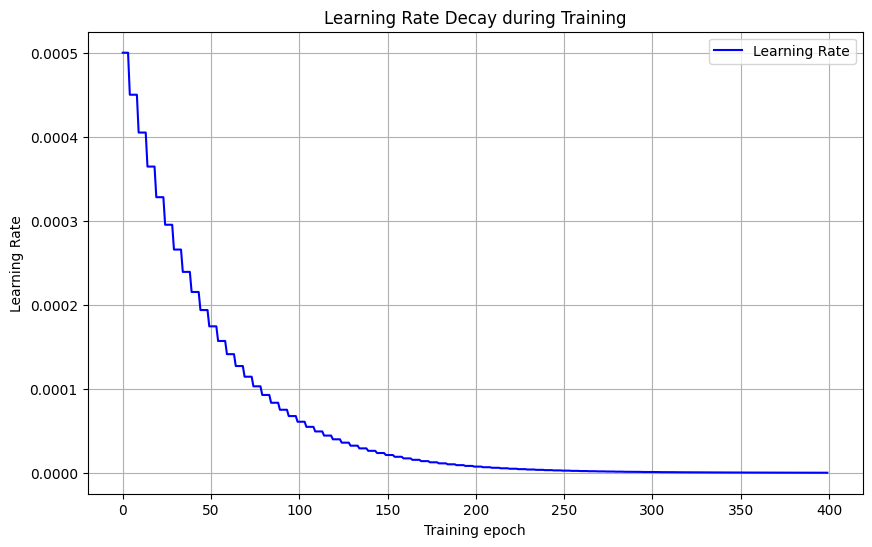

Training finished.


In [85]:
# 用于记录每个step的学习率
lr_history = []
best_val_loss = float('inf')  # 初始设为无穷大，以便后续能够找到更低的损失值
best_model_state = None

train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses

for epoch in range(num_epochs):
    # Training phase
    net.train()
    train_loss = 0.0
    
    for X, y in train_loader_iter:
        optimizer.zero_grad()
        outputs = net(X)
        loss_value = loss(outputs, y)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()
        
    train_losses.append(train_loss)  # Store the training loss  

    # 每经过5个epoch，学习率衰减一次
    if (epoch + 1) % 5 == 0:  # 每5个epoch更新一次学习率
        scheduler.step()

    # 打印每个epoch的学习率
    current_lr = scheduler.get_last_lr()[0]
    lr_history.append(current_lr)  # 记录当前batch的学习率
    print(f"Epoch [{epoch+1}/{num_epochs}], traning_Loss: {train_loss/len(train_loader_iter):.4f}, Learning Rate: {current_lr:.8f}")

    # 每5个epoch打印一次
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1} completed. Learning Rate: {current_lr:.8f}")

   
    # Validation phase
    net.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_val, y_val in valid_loader_iter:
            outputs = net(X_val)
            val_loss += loss(outputs, y_val).item()
            
    val_losses.append(val_loss)  # Store the validation loss
    
    # Check if this is the best model by validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = net.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}], validation_Loss: {val_loss/len(valid_loader_iter):.4f}, Learning Rate: {current_lr:.8f}")
    
# Save the best model state
torch.save(best_model_state, 'best_model_project_a.pth')

# 训练结束后，绘制学习率曲线
plt.figure(figsize=(10, 6))
plt.plot(lr_history, label='Learning Rate', color='b')
plt.xlabel('Training epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay during Training')
plt.legend()
plt.grid(True)
plt.show()

print("Training finished.")

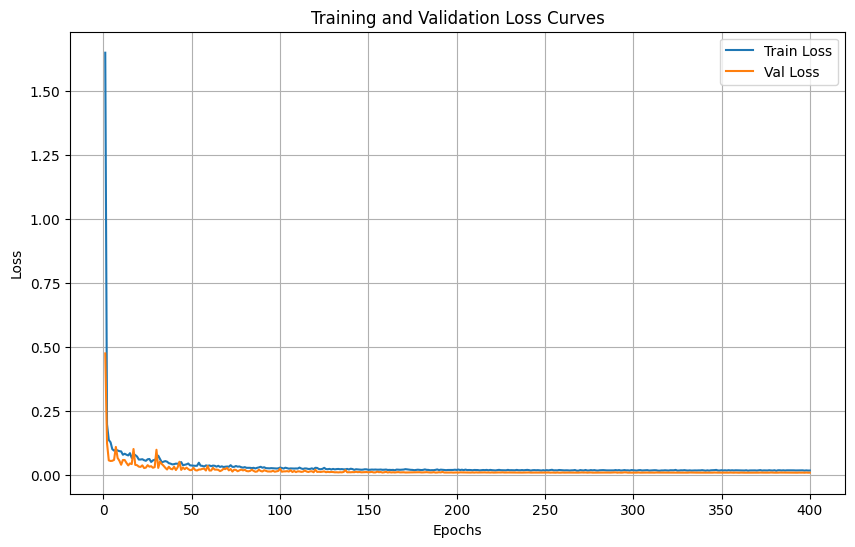

In [86]:
# Plotting the training and validation loss curves 
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), [loss / len(train_loader_iter) for loss in train_losses], label='Train Loss')
plt.plot(range(1, num_epochs + 1), [loss / len(valid_loader_iter) for loss in val_losses], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# Step 2: Load the best model state
best_model = torch.load('best_model_project_a.pth')

# Step 3: Load state dict into the model
net.load_state_dict(best_model)

# Step 4: Set the model to evaluation mode
net.eval()

# Step 5: Evaluate on the test set
test_loss = 0.0

with torch.no_grad():
    for X_test, y_test in test_loader_iter:
        outputs = net(X_test)
        test_loss += loss(outputs, y_test).item() * X_test.size(0)

# Calculate average test loss
test_loss = test_loss / len(test_loader_iter.dataset)

print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0087


In [ ]:
Epoch [381/400], traning_Loss: 0.0153, Learning Rate: 0.00000017
Epoch [381/400], validation_Loss: 0.0080, Learning Rate: 0.00000017

In [88]:
test_folder = r'F:\ptdatav3\1500_nor\test'  # 输入文件所在目录
input_files = sorted([f for f in os.listdir(test_folder) if f.startswith('input') and f.endswith('.pt')])  # 查找所有 input{i}.pt 文件
target_files = sorted([f for f in os.listdir(test_folder) if f.startswith('target') and f.endswith('.pt')])  # 查找所有 target{i}.pt 文件

# # Step 3: 只处理前 600 个文件
# input_files = input_files[:200]  # 只选择前 600 个 input 文件
# target_files = target_files[:200]  # 只选择前 600 个 target 文件

# Step 4: 初始化保存结果的列表
A_values = []  # 用于存储 A 值
predicted_outputs = []  # 用于存储预测结果
true_outputs = []  # 用于存储真实结果

# Step 5: 逐个加载 input 和 target 文件，进行预测并计算 A
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)  # 确保模型在正确的设备上

for input_file, target_file in zip(input_files, target_files):
    # 加载输入和目标张量
    input_tensor = torch.load(os.path.join(test_folder, input_file)).to(device)
    output_tensor = torch.load(os.path.join(test_folder, target_file)).to(device)
    
    # 进行预测
    with torch.no_grad():
        predicted_output = net(input_tensor.unsqueeze(0)) * target_std + target_mean   # 预测结果
        output_tensor = output_tensor * target_std + target_mean  # 转换目标张量到原始尺度
    
    # 计算 A 值
    A = (output_tensor - predicted_output) / output_tensor  # A 计算公式

    # 将预测结果、真实结果和 A 值转回 CPU 并转为 NumPy 数组 (去除 batch 维度)
    predicted_outputs.append(predicted_output.squeeze().cpu().numpy())  # 去掉 batch 维度，得到 (20, 20)
    true_outputs.append(output_tensor.squeeze().cpu().numpy())  # 去掉 batch 维度，得到 (20, 20)
    A_values.append(A.squeeze().cpu().numpy())  # 计算 A 值，并去掉 batch 维度，得到 (20, 20)

# Step 6: 将结果转换为 NumPy 数组，形状应为 (600, 20, 20)
predicted_outputs = np.array(predicted_outputs)  # 形状为 (600, 20, 20)
true_outputs = np.array(true_outputs)  # 形状为 (600, 20, 20)
A_matrix = np.array(A_values)  # 形状为 (600, 20, 20)

# 打印输出的形状
print(f"Predicted outputs shape: {predicted_outputs.shape}")  # 打印预测输出的形状
print(f"True outputs shape: {true_outputs.shape}")  # 打印真实输出的形状
print(f"A matrix shape: {A_matrix.shape}")  # 打印 A 的形状

# Step 7: 输出最后一个预测结果和真实结果
print(f"Last predicted_output: {predicted_outputs[0]}")  
print(f"Last true output_tensor: {true_outputs[0]}")  
print(f"Last A: {A_matrix[0]}") 

Predicted outputs shape: (64, 20, 20)
True outputs shape: (64, 20, 20)
A matrix shape: (64, 20, 20)
Last predicted_output: [[ 934.42786  776.34454  938.15594  943.69037  959.4042   969.9933
   970.3779  1165.8665   941.7968   758.1701   782.86615  772.3096
   951.6085   919.2907   890.1293   860.1937   854.519    940.84314
  1122.702    921.2679 ]
 [ 678.6708   945.4613   926.34845 1134.7284  1073.1469  1202.1836
  1188.5215  1114.8916   939.1109   941.03827  779.0393   961.6007
   883.5861  1049.0024   936.5665   951.73315  942.1358  1035.1715
   875.7525   982.5693 ]
 [ 752.27203  940.2372  1094.3995  1084.1703  1046.6829  1018.1622
  1027.9489   997.1263  1053.8279   940.7164   779.1252  1151.8903
   970.5661   933.70984  940.0222  1191.3586   934.92804  931.3438
   961.17285  953.18976]
 [1072.5087   941.6576   958.8813  1032.8811   923.9889   926.5027
   922.87146 1174.6012   961.2085   938.2883  1079.4865   910.63135
   940.0792  1058.2605   943.9245   943.10455  938.98663 1057.9

In [89]:
A_matrix_flattened = A_matrix.reshape(64, 400)

In [90]:
A_matrix_flattened_cut=A_matrix_flattened[0:16]

In [91]:
A_matrix_flattened_cut_abs = np.abs(A_matrix_flattened_cut)

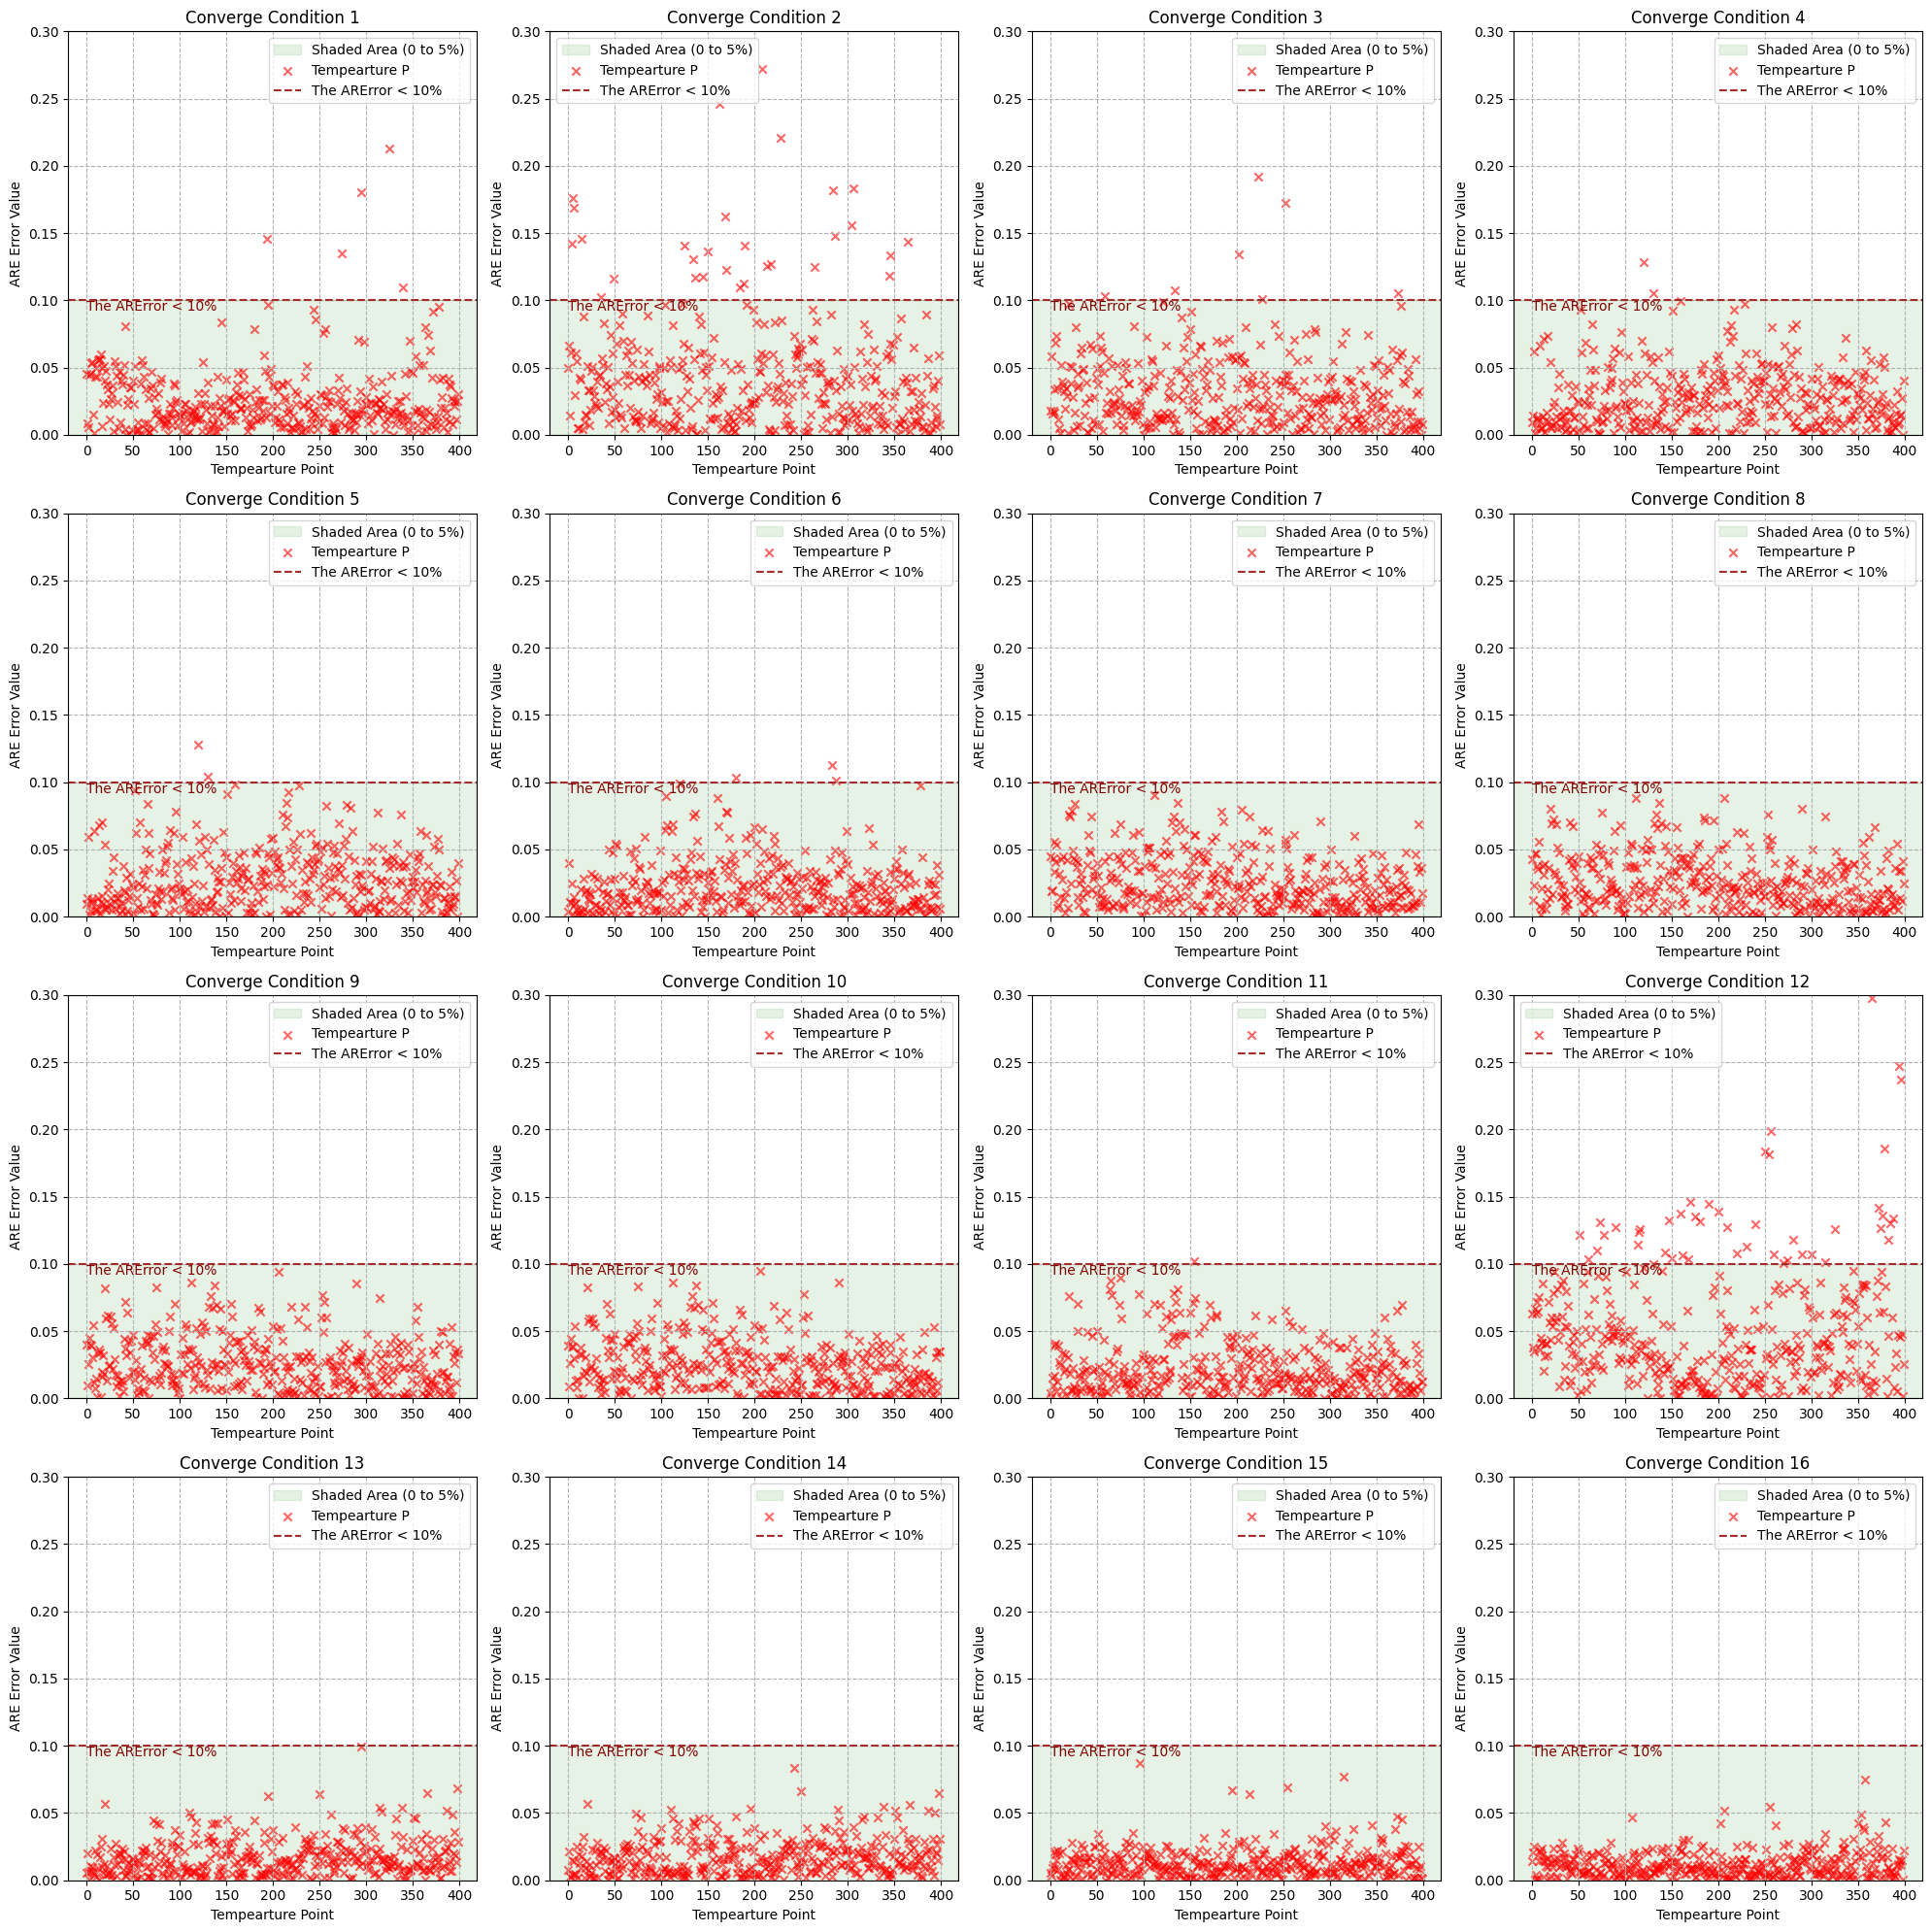

In [104]:
num_samples = A_matrix_flattened_cut_abs .shape[0]  # 样本数量，这里是 64
samples_per_row = 4  # 每行图像数量

# 创建一个 figure 和多个子图 (8行 x 8列)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))  # 8x8 网格
axes = axes.flatten()  # 将二维数组展平，方便一一访问

# 绘制每个样本的散点图
for i in range(num_samples):
    ax = axes[i]  # 选择当前的子图
    ax.axhspan(0, 0.1, color='green', alpha=0.1, label='Shaded Area (0 to 5%)')
    ax.scatter(range(400), A_matrix_flattened_cut_abs [i], color='red', marker='x', alpha=0.6, label='Tempearture P')
    ax.axhline(y=0.1, color='brown', linestyle='--', label='The ARError < 10%')
    ax.text(0, 0.1, 'The ARError < 10%', color='maroon', verticalalignment='top', horizontalalignment='left')
    ax.set_title(f'Converge Condition {i+1}')
    ax.set_xlabel('Tempearture Point')
    ax.set_ylim(0, 0.3)
    ax.set_ylabel('ARE Error Value')
    ax.grid(True, linestyle='--')
    ax.legend()

# 调整布局，确保子图不会重叠
plt.tight_layout()
plt.show()

In [101]:
A_matrix_flattened_cut_A=A_matrix_flattened[0:64]

In [102]:
A_matrix_flattened_cut_A_abs = np.abs(A_matrix_flattened_cut_A)

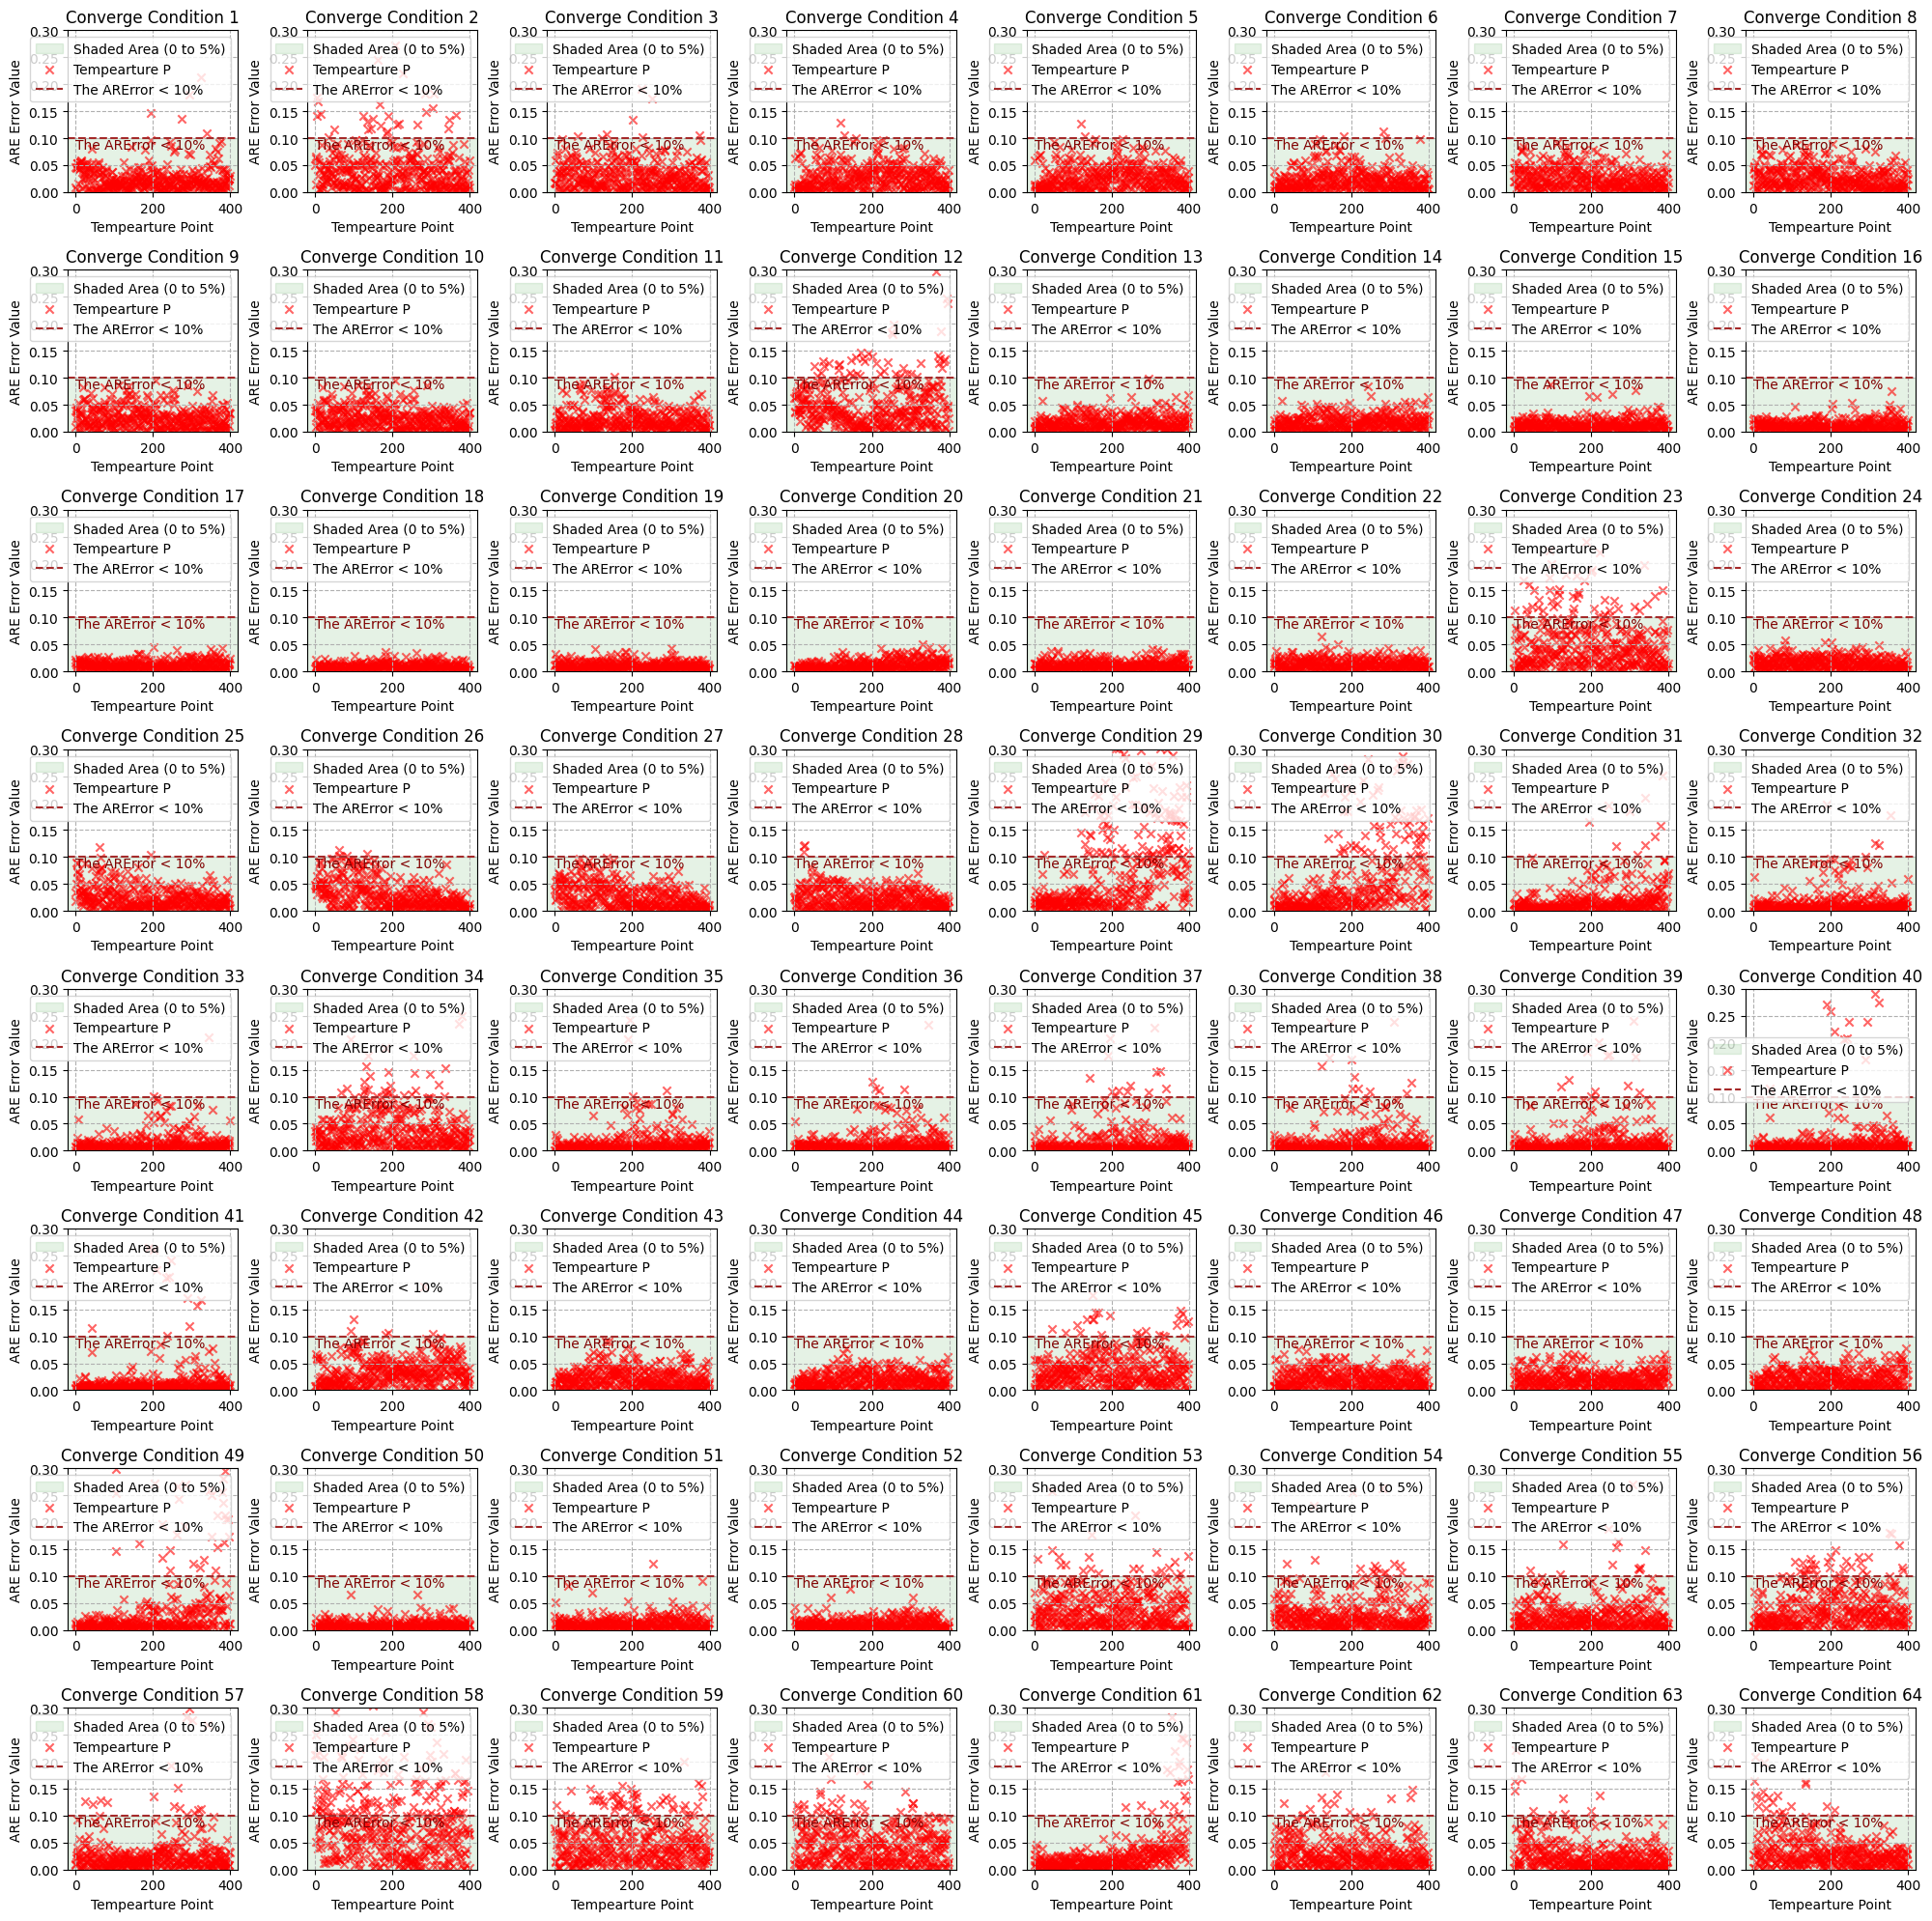

In [105]:
num_samples = A_matrix_flattened_cut_A_abs .shape[0]  # 样本数量，这里是 64
samples_per_row = 6  # 每行图像数量

# 创建一个 figure 和多个子图 (8行 x 8列)
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))  # 8x8 网格
axes = axes.flatten()  # 将二维数组展平，方便一一访问

# 绘制每个样本的散点图
for i in range(num_samples):
    ax = axes[i]  # 选择当前的子图
    ax.axhspan(0, 0.1, color='green', alpha=0.1, label='Shaded Area (0 to 5%)')
    ax.scatter(range(400), A_matrix_flattened_cut_A_abs [i], color='red', marker='x', alpha=0.6, label='Tempearture P')
    ax.axhline(y=0.1, color='brown', linestyle='--', label='The ARError < 10%')
    ax.text(0, 0.1, 'The ARError < 10%', color='maroon', verticalalignment='top', horizontalalignment='left')
    ax.set_title(f'Converge Condition {i+1}')
    ax.set_xlabel('Tempearture Point')
    ax.set_ylim(0, 0.3)
    ax.set_ylabel('ARE Error Value')
    ax.grid(True, linestyle='--')
    ax.legend()

# 调整布局，确保子图不会重叠
plt.tight_layout()
plt.show()

In [106]:
# Step 1: Flatten the predicted and true outputs to shape (64, 400)
predicted_outputs_flat = predicted_outputs.reshape(64, -1)  # 将预测结果展平为 (64, 400)
true_outputs_flat = true_outputs.reshape(64, -1)  # 将真实结果展平为 (64, 400)

# Step 2: 计算 MAPE, RMSE 和 R²

# 计算 MAPE
def calculate_mape(true, predicted):
    # 防止除零错误，取真值不为零的部分
    return np.mean(np.abs((true - predicted) / true)) * 100

# 计算 RMSE
def calculate_rmse(true, predicted):
    return np.sqrt(np.mean((true - predicted) ** 2))

# 计算 R²
def calculate_r2(true, predicted):
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    ss_res = np.sum((true - predicted) ** 2)
    return 1 - (ss_res / ss_tot)

# 计算每个样本的 MAPE、RMSE 和 R²
mape_values = []
rmse_values = []
r2_values = []

for i in range(predicted_outputs_flat.shape[0]):
    true = true_outputs_flat[i]
    predicted = predicted_outputs_flat[i]
    
    mape = calculate_mape(true, predicted)
    rmse = calculate_rmse(true, predicted)
    r2 = calculate_r2(true, predicted)
    
    mape_values.append(mape)
    rmse_values.append(rmse)
    r2_values.append(r2)

# 转换为 NumPy 数组
mape_values = np.array(mape_values)
rmse_values = np.array(rmse_values)
r2_values = np.array(r2_values)

# Step 3: 打印输出
print(f"MAPE values for each sample: {mape_values}")
print(f"RMSE values for each sample: {rmse_values}")
print(f"R2 values for each sample: {r2_values}")

# 计算并输出均值
print(f"Mean MAPE: {np.mean(mape_values)}")
print(f"Mean RMSE: {np.mean(rmse_values)}")
print(f"Mean R2: {np.mean(r2_values)}")

MAPE values for each sample: [ 2.52883881  4.13019806  3.10550481  2.75754929  2.78160088  2.24348307
  2.57870983  2.63320133  2.63330843  2.53349729  2.28743646  4.99137305
  1.70559511  1.76684503  1.31748132  1.18840169  1.14578474  0.84469747
  0.98147187  1.17262034  1.12607069  1.35487458  4.79237176  1.59463547
  2.42943484  2.98325401  2.67710332  2.348979   10.00331491  9.25035104
  2.35172827  1.44031001  1.58356931  3.96316424  1.35968318  1.61642805
  1.62940174  1.94681864  1.69499554  1.85674671  1.80883184  3.40826288
  2.32083444  2.01766565  3.90412994  2.22200528  2.1332955   2.18120962
  5.47783524  0.85896822  1.21367984  1.13388542  3.90070528  3.13372165
  2.82204989  3.91256064  2.78643798  8.27972218  4.94702011  4.54553328
  3.19412909  3.11589334  2.70941146  3.35039124]
RMSE values for each sample: [ 33.541035   21.050003   15.173601   13.3937235  13.536455   11.607627
  12.047704   12.204305   12.13689    11.733668   10.977043   59.29872
   8.629221    8.70